# Model Training
Train the model from the /train folder. Gets class types through the names of folders each image is in. Then saves the model to the project directory.

In [1]:
import numpy as np
import tensorflow as tf
import cv2

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

data_dir = "./train"
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4229


In [3]:
batch_size = 32
img_height = 64
img_width = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4229 files belonging to 26 classes.
Using 3384 files for training.
Found 4229 files belonging to 26 classes.
Using 845 files for validation.
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'qu', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Example Data Image + Labels

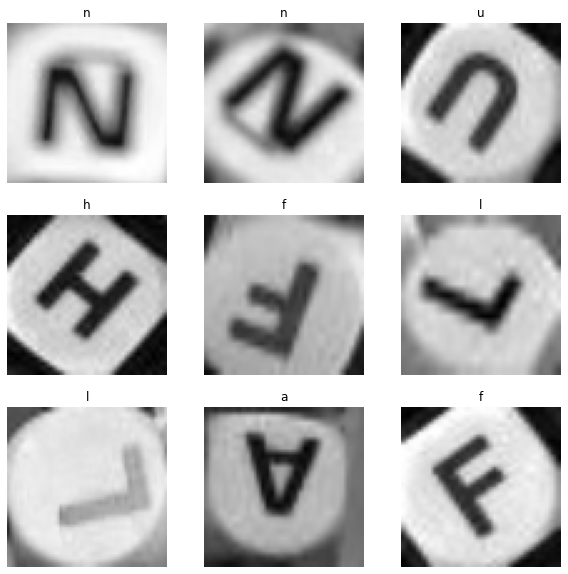

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Model Creation

In [16]:
train_ds = train_ds.cache().shuffle(3384).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


num_classes = len(class_names)

model = Sequential([
  # the following three layers are not allowed in TFJS
  # layers.Resizing(img_height, img_width, input_shape=(img_height, img_width, 3)),
  # layers.Rescaling(1./255),
  # layers.RandomRotation(0.2),
  layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# model.summary()

### Train

In [17]:
EPOCHS = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

Epoch 1/10
106/106 [==============================] - 17s 155ms/step - loss: 11.4939 - accuracy: 0.1096 - val_loss: 2.8686 - val_accuracy: 0.1669
Epoch 2/10
106/106 [==============================] - 15s 144ms/step - loss: 2.6718 - accuracy: 0.2210 - val_loss: 2.5490 - val_accuracy: 0.2544
Epoch 3/10
106/106 [==============================] - 15s 140ms/step - loss: 2.4548 - accuracy: 0.2730 - val_loss: 2.5838 - val_accuracy: 0.2533
Epoch 4/10
106/106 [==============================] - 17s 157ms/step - loss: 2.5377 - accuracy: 0.2592 - val_loss: 2.6946 - val_accuracy: 0.2225
Epoch 5/10
106/106 [==============================] - 20s 188ms/step - loss: 2.2134 - accuracy: 0.3416 - val_loss: 2.3844 - val_accuracy: 0.3550
Epoch 6/10
106/106 [==============================] - 17s 159ms/step - loss: 1.9606 - accuracy: 0.4137 - val_loss: 2.2540 - val_accuracy: 0.3598
Epoch 7/10
106/106 [==============================] - 17s 157ms/step - loss: 1.8394 - accuracy: 0.4498 - val_loss: 2.2166 - val_a

In [18]:
# save the model
model_name = "roggle_letter_classifier"
model_path = "./model/" + model_name
model.save_weights(model_path)
model.save("./model/" + model_name, save_format='h5')

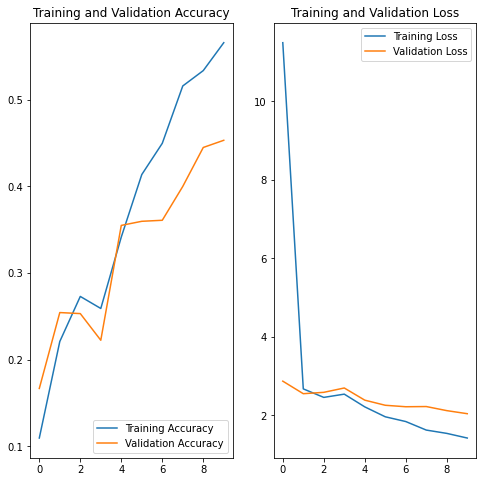

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Inference

1/1 [==============================] - 0s 59ms/step



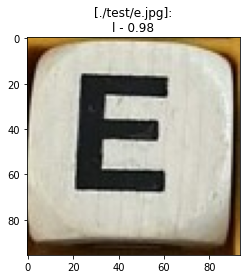

In [22]:
model = tf.keras.models.load_model("./model/" + model_name)
img_path = "./test/e.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])


image_to_display = cv2.imread(img_path)
image_to_display = cv2.cvtColor(image_to_display, cv2.COLOR_BGR2RGB)

print()
plt.imshow(image_to_display)
plt.title("[{}]:\n{} - {:.2f}".format(img_path, class_names[np.argmax(score)],  10 * np.max(score)))
plt.show()

### Convert from Keras model format to TFJS format


In [23]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "./model_tfjs")